In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [4]:
from google.colab import files
uploaded = files.upload()


Saving german_credit_data.csv to german_credit_data.csv


In [5]:
df = pd.read_csv('/content/german_credit_data.csv')  # Use correct path if uploaded to Colab

# Drop index column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Basic info
print(df.info())
print(df.describe())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB
None
               Age          Job  Credit amount     Duration
count  1000.000000  1000.000000    1000.000000  1000.000000
mean     35.546000     1.904000    3271.258000    20.903000
std      11.375469     0.653614    2822.736876    12.058814
min      19.000000     0.000000     250.000000

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [6]:
# Check missing values
df.isnull().sum()

# Fill missing categorical values with 'missing'
df['Saving accounts'].fillna('no_info', inplace=True)
df['Checking account'].fillna('no_info', inplace=True)


<ipython-input-6-13ef54b6eff6>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Saving accounts'].fillna('no_info', inplace=True)
<ipython-input-6-13ef54b6eff6>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

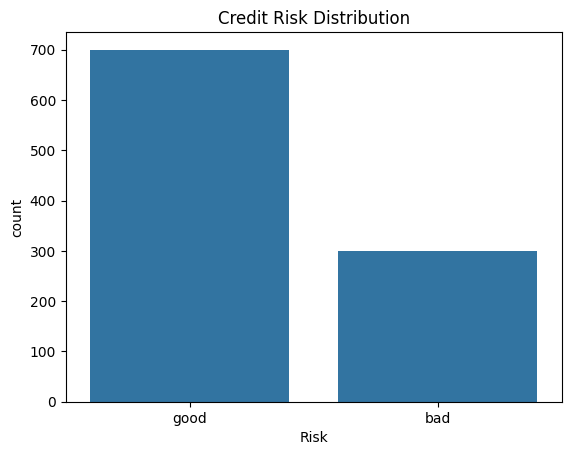

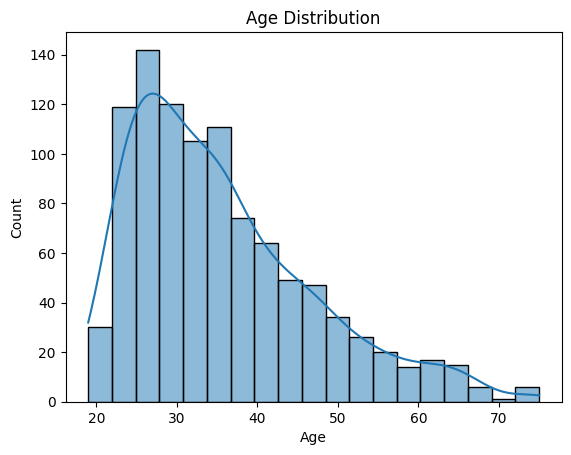

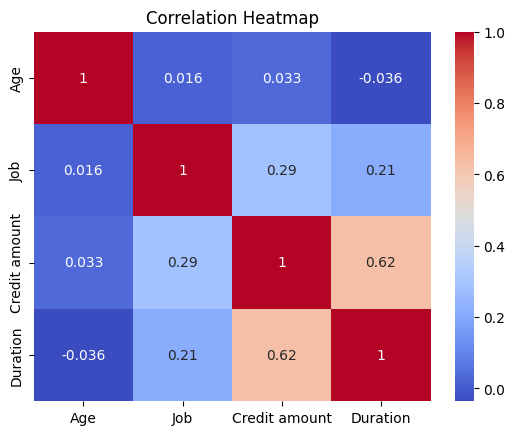

In [7]:
# Target distribution
sns.countplot(x='Risk', data=df)
plt.title("Credit Risk Distribution")
plt.show()

# Age distribution
sns.histplot(df['Age'], kde=True)
plt.title("Age Distribution")
plt.show()

# Correlation heatmap for numeric columns
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [8]:
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Encode target
df_encoded['Risk'] = df_encoded['Risk'].map({'good': 0, 'bad': 1})


In [9]:
X = df_encoded.drop('Risk', axis=1)
y = df_encoded['Risk']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [10]:
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, preds))



Logistic Regression
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       141
           1       0.63      0.41      0.49        59

    accuracy                           0.76       200
   macro avg       0.71      0.65      0.67       200
weighted avg       0.74      0.76      0.74       200


Random Forest
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       141
           1       0.61      0.37      0.46        59

    accuracy                           0.74       200
   macro avg       0.69      0.64      0.65       200
weighted avg       0.73      0.74      0.72       200


Support Vector Machine
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       141
           1       0.70      0.36      0.47        59

    accuracy                           0.77       200
   macro avg       0.74      0.65      0.66       200
weighted avg  

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:15:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


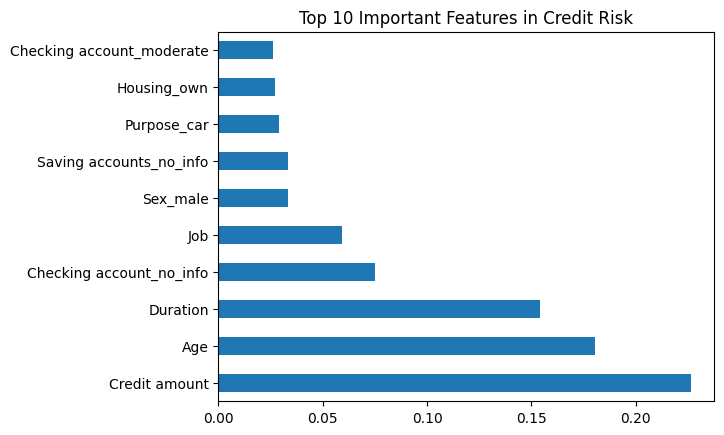

In [11]:
#Feature Importance (for random forest)
rf = models["Random Forest"]
importances = rf.feature_importances_
features = X.columns

# Top 10 features
top_features = pd.Series(importances, index=features).nlargest(10)
top_features.plot(kind='barh')
plt.title("Top 10 Important Features in Credit Risk")
plt.show()


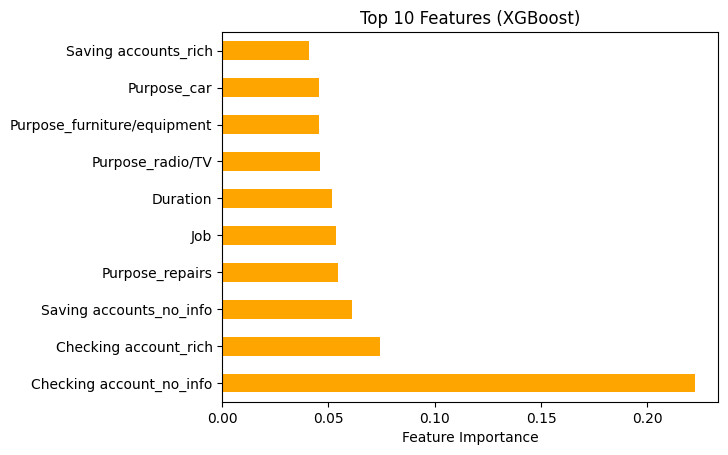

In [12]:
#Feature Importance from XGBoost
xgb_model = models["XGBoost"]
xgb_importance = xgb_model.feature_importances_

# Top 10 features from XGBoost
xgb_top_features = pd.Series(xgb_importance, index=X.columns).nlargest(10)
xgb_top_features.plot(kind='barh', color='orange')
plt.title("Top 10 Features (XGBoost)")
plt.xlabel("Feature Importance")
plt.show()



In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid,
                              cv=5, scoring='f1', n_jobs=-1, verbose=1)

rf_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=1)

Best Parameters (Random Forest): {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report for Optimized Random Forest:

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       141
           1       0.56      0.37      0.45        59

    accuracy                           0.73       200
   macro avg       0.67      0.63      0.64       200
weighted avg       0.71      0.73      0.71       200



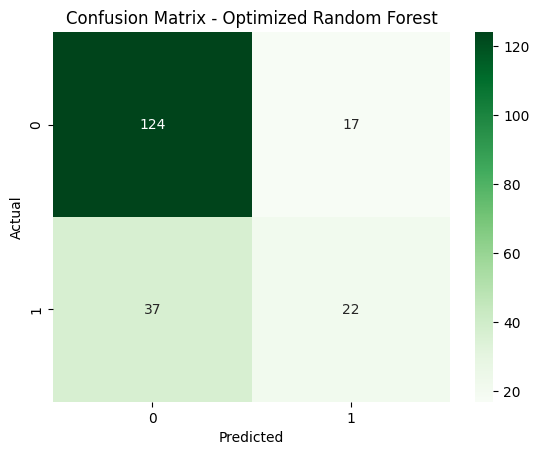

In [14]:
# Best parameters and model
print("Best Parameters (Random Forest):", rf_grid_search.best_params_)

best_rf = rf_grid_search.best_estimator_
rf_preds = best_rf.predict(X_test)

print("Classification Report for Optimized Random Forest:\n")
print(classification_report(y_test, rf_preds))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Optimized Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


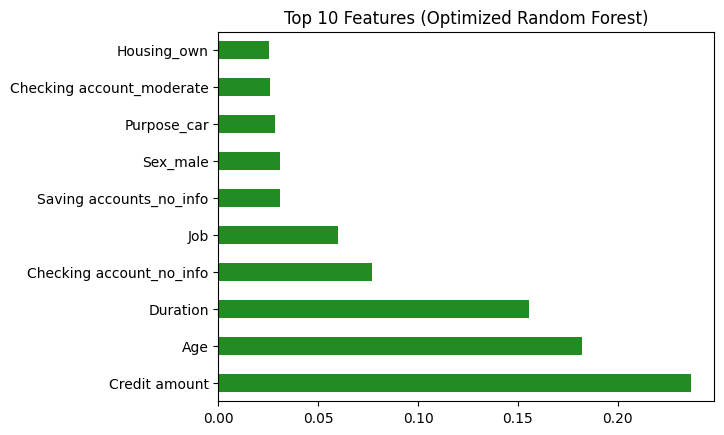

In [15]:
rf_importances = best_rf.feature_importances_
rf_top_features = pd.Series(rf_importances, index=X.columns).nlargest(10)

rf_top_features.plot(kind='barh', color='forestgreen')
plt.title("Top 10 Features (Optimized Random Forest)")
plt.show()


In [16]:
from sklearn.model_selection import cross_val_score

rf_cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='f1')
print("Random Forest Cross-Validation F1 Scores:", rf_cv_scores)
print("Average F1 Score (Random Forest):", np.mean(rf_cv_scores))


Random Forest Cross-Validation F1 Scores: [0.41071429 0.47058824 0.3655914  0.5046729  0.55769231]
Average F1 Score (Random Forest): 0.46185182474928704


In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVC()

svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid,
                                cv=5, scoring='f1', verbose=1, n_jobs=-1)

svm_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='f1', verbose=1)

Best Parameters (SVM): {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report for Optimized SVM:

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       141
           1       0.59      0.37      0.46        59

    accuracy                           0.74       200
   macro avg       0.68      0.63      0.64       200
weighted avg       0.72      0.74      0.72       200



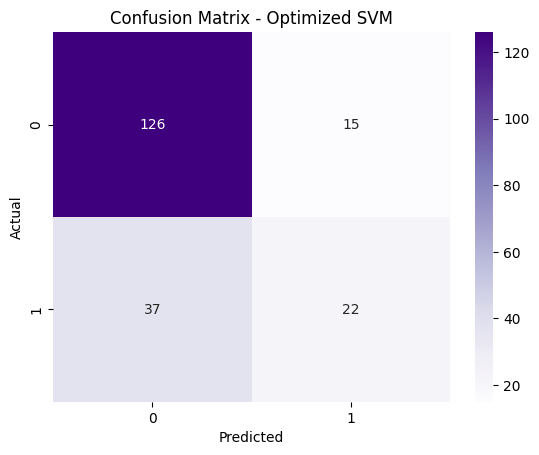

In [18]:
# Best parameters and predictions
print("Best Parameters (SVM):", svm_grid_search.best_params_)

best_svm = svm_grid_search.best_estimator_
svm_preds = best_svm.predict(X_test)

print("Classification Report for Optimized SVM:\n")
print(classification_report(y_test, svm_preds))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Optimized SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:
pip install streamlit


In [20]:
import joblib

# Save all trained models
joblib.dump(models["Logistic Regression"], "logistic_regression_model.pkl")
joblib.dump(models["Random Forest"], "random_forest_model.pkl")
joblib.dump(models["Support Vector Machine"], "svm_model.pkl")
joblib.dump(models["XGBoost"], "xgboost_model.pkl")

# Save optimized models if available
joblib.dump(best_rf, "best_random_forest_model.pkl")
joblib.dump(best_svm, "best_svm_model.pkl")

# Save the scaler
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [21]:
from google.colab import files
files.download("logistic_regression_model.pkl")
files.download("random_forest_model.pkl")
files.download("svm_model.pkl")
files.download("xgboost_model.pkl")
files.download("best_random_forest_model.pkl")
files.download("best_svm_model.pkl")
files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import sklearn
print(sklearn.__version__)


1.6.1
